In [18]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import tikzplotlib
from math import ceil, floor

In [19]:
from traces.constants import SUBMISSION_TIME, START_TIME, END_TIME, JOB_TYPE, SOURCE
from lib.utils import timedelta, summarize_distribution, distance_distribution, plot_cdf, scale_xaxis

# Inputs

In [20]:
TRACE = 'traces/facebook/out/2010.csv'

# time slot length, used for plotting and estimation of some statistics (e.g. PMR)
DELTA = 10 * 60
TIME_SLOTS_PER_HOUR = floor((60 * 60) / DELTA)
TIME_SLOTS_PER_DAY = floor((24 * 60 * 60) / DELTA)

# Analysis

In [21]:
t = pd.read_csv(TRACE)

## Number of jobs

In [22]:
number_of_jobs = t.shape[0]
number_of_jobs

6638

## Number of job types

In [23]:
number_of_job_types = t[[JOB_TYPE, SOURCE]].nunique()
number_of_job_types

job_type    1
source      1
dtype: int64

## Duration

In [24]:
final_submission_time = t.iloc[-1][SUBMISSION_TIME] - t.iloc[0][SUBMISSION_TIME]
duration = timedelta(final_submission_time)
duration

TimeDelta(d=0, h=23, m=59, s=39)

## Interarrival time / submission rate

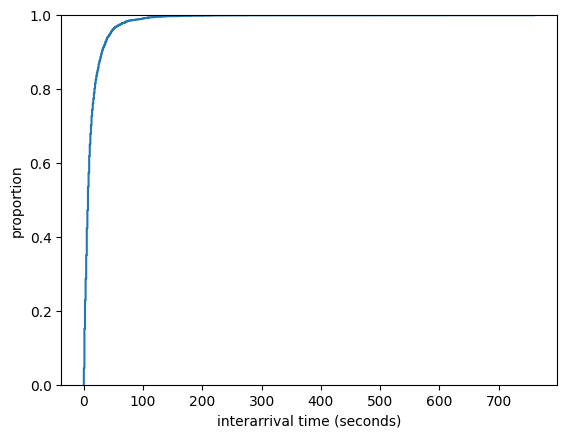

DistributionSummary(mean=13.016269960831576, median=7.0, modes=array([1]), std=22.286200641097448, mad=5.0, min_=0, p25=3.0, p75=15.0, max_=761)

In [25]:
interarrival_times = distance_distribution(t[SUBMISSION_TIME])
plot_cdf(interarrival_times, 'interarrival time (seconds)', 'interarrival_times')
plt.show()
summary = summarize_distribution(interarrival_times)

# sanity check
assert np.absolute(summary.mean - final_submission_time / number_of_jobs) < 1, f'{summary.mean}, {final_submission_time / number_of_jobs}'

summary

## Load profiles

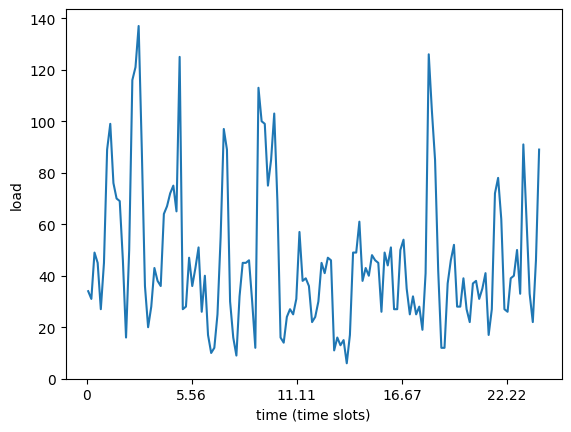

DistributionSummary(mean=46.09722222222222, median=40.0, modes=array([27]), std=27.599144371913567, mad=13.0, min_=6, p25=27.0, p75=54.25, max_=137)

In [26]:
fig = sb.histplot(t[SUBMISSION_TIME], binwidth=DELTA, element='poly', fill=False)
scale_xaxis(fig, 1 / (60 * 60))
plt.xlabel('time (time slots)')
plt.ylabel('load')
tikzplotlib.save('out/figures/histogram.tex')
plt.show()

fig = sb.histplot(t[SUBMISSION_TIME], binwidth=DELTA)
loads = np.array([h.get_height() for h in fig.patches])
plt.clf()
summarize_distribution(loads)

### Load Profiles per day

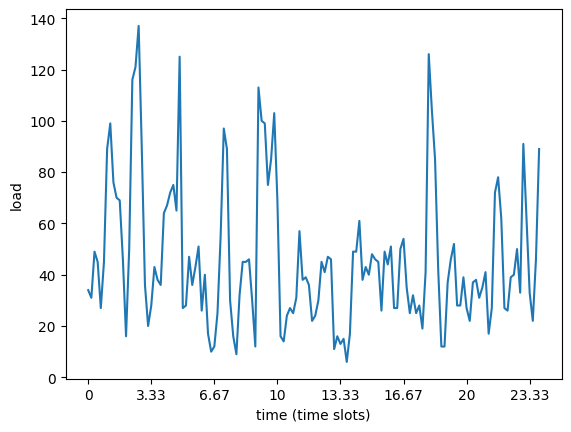

In [27]:
number_of_days = ceil(loads.shape[0] / TIME_SLOTS_PER_DAY)

# xs = np.array_split(loads, number_of_days, axis=0)
# xs.append(np.array_split(loads, number_of_days, axis=0))
# xs.append(np.array_split(loads, number_of_days, axis=0))
# xs.append(np.array_split(loads, number_of_days, axis=0))
# xs.append(np.array_split(loads, number_of_days, axis=0))
# # loads_during_day = np.dstack(xs)[0]

d = {'time (time slots)': (list(np.arange(TIME_SLOTS_PER_DAY)) * number_of_days)[:loads.shape[0]], 'load': loads, 'hue': np.repeat('', loads.shape[0])}
df = pd.DataFrame(d)
# loads_during_day
fig = sb.lineplot(data=df, x='time (time slots)', y='load', hue='hue', ci=75)
scale_xaxis(fig, 1 / TIME_SLOTS_PER_HOUR)
tikzplotlib.save('out/figures/histogram_day.tex')
plt.show()

## Peak-to-mean ratio

In [28]:
loads.max() / loads.mean()

2.971979511901175

## True peak-to-mean ratio

In [29]:
np.quantile(loads, 0.9) / loads.mean()

1.9307020186803254

### Peak distance

Distance between peaks. A peak is a time slot with load greater than the 0.75-quantile.

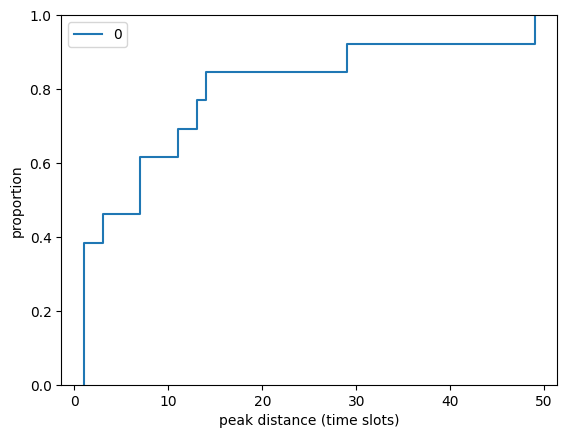

DistributionSummary(mean=10.615384615384615, median=7.0, modes=array([[1]]), std=13.516590725921645, mad=array([6.]), min_=1, p25=1.0, p75=13.0, max_=49)

In [30]:
peaks = np.argwhere(loads > np.quantile(loads, 0.9))
peak_distances = distance_distribution(peaks)
plot_cdf(peak_distances, 'peak distance (time slots)', 'peak_distances', xaxis_factor=1 / TIME_SLOTS_PER_HOUR)
plt.show()
summarize_distribution(peak_distances)

### Valley length

Number of time slots up to each time slot with a smaller load.

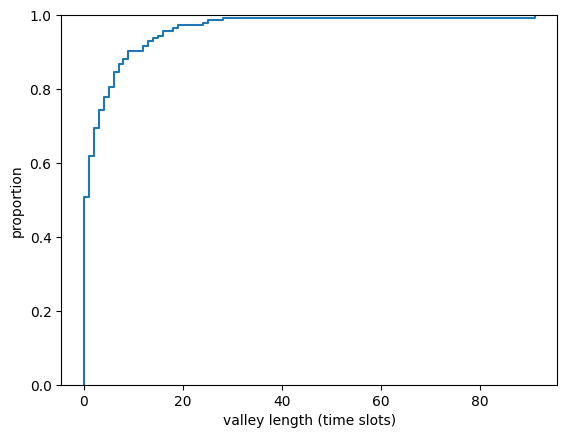

DistributionSummary(mean=3.576388888888889, median=0.0, modes=array([0]), std=9.015865538278673, mad=0.0, min_=0, p25=0.0, p75=4.0, max_=91)

In [31]:
valley_lengths = np.array([i - (np.argwhere(loads[:i] >= loads[i]).max(initial=-1)) - 1 for i in range(loads.shape[0])])
plot_cdf(valley_lengths, 'valley length (time slots)', 'valley_lengths', xaxis_factor=1 / TIME_SLOTS_PER_HOUR)
plt.show()
summarize_distribution(valley_lengths)

### Diurnal pattern

Loads follow a diurnal pattern if during every 24 hour period (excluding the first day) there is at least one time slot with a valley length greater or equals to 12 hours.

In [32]:
if duration.d > 1:
  print(np.array([np.array([valley_lengths[i * TIME_SLOTS_PER_DAY + j] >= 12 for j in range(24)]).any() for i in range(1, floor(valley_lengths.shape[0] / TIME_SLOTS_PER_DAY))]).all())
else:
  print('trace is too short')

trace is too short


## Job duration

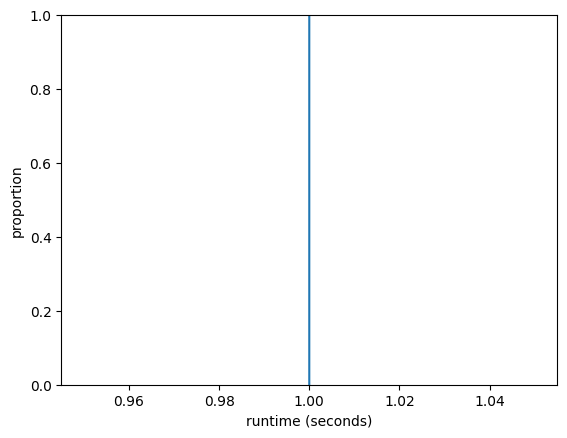

DistributionSummary(mean=1.0, median=1.0, modes=array([1]), std=0.0, mad=0.0, min_=1, p25=1.0, p75=1.0, max_=1)

In [33]:
t_n = t.dropna(axis='rows', subset=[START_TIME, END_TIME])
runtime = t_n[END_TIME] - t_n[START_TIME]
plot_cdf(runtime, 'runtime (seconds)', 'runtime')
plt.show()
summarize_distribution(runtime.to_numpy())

## Scheduling rate / queueing delay

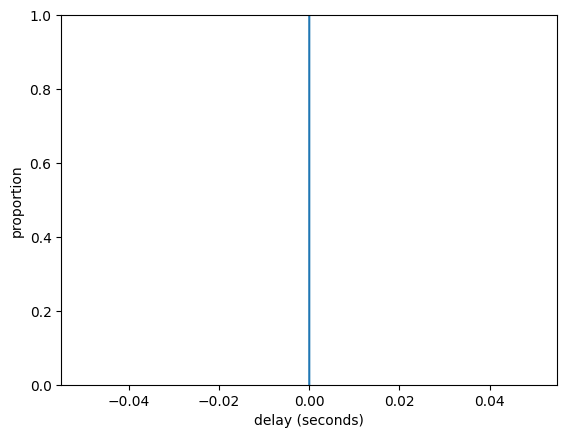

DistributionSummary(mean=0.0, median=0.0, modes=array([0]), std=0.0, mad=0.0, min_=0, p25=0.0, p75=0.0, max_=0)

In [34]:
queueing_delay = t_n[START_TIME] - t_n[SUBMISSION_TIME]
plot_cdf(queueing_delay, 'delay (seconds)', 'queueing_delay')
plt.show()
summarize_distribution(queueing_delay.to_numpy())